In [1]:
import pickle
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
from gala.coordinates import reflex_correct

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
import scipy.stats


def getDust(G, bp, rp, ebv, maxnit=10):
    """ Compute the Gaia extinctions assuming relations from Babusieux
    Arguments: G, bp, rp, E(B-V)
    maxnit -- number of iterations
    Returns extinction in G,bp, rp
    Author: Sergey Koposov skoposov@cmu.edu
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        print(scipy.stats.scoreatpercentile(delta[np.isfinite(delta)], 99))
        curbp = curbp1
    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


In [4]:
with open('gaiaRRlyrae.pkl', 'rb') as f:
    d = Table(pickle.load(f))


In [5]:
Ag, Abp, Arp = getDust(d['int_average_g'], d['phot_bp_mean_mag'], d['phot_rp_mean_mag'], d['ebv'])

3.1443763446807864
0.5065959620475795
0.3024415850639551
0.18543516159057688
0.07993161678314263
0.026179099082946702
0.009283938407898554
0.003983092308044375
0.0019087672233581293
0.0010056304931640309


/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in add
/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [6]:
bprp = (d['phot_bp_mean_mag'] - Abp) - (d['phot_rp_mean_mag'] - Arp)

In [7]:
good = ~np.isnan(d['pmra']) & ~np.isnan(d['pmdec']) & (d['ebv'] < 5) & (bprp < 1) & (Ag < 5) & (d['best_classification'] == 'RRab')

/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [8]:
data = d[good]

In [9]:
def calc_distance(g, Ag):
    #Ag = 2.5*ebv
    gmag = g-Ag
    dist = 10.*10.**(0.2*(gmag-0.5))*1e-3
    return dist

In [10]:
Ag, Abp, Arp = getDust(data['int_average_g'], data['phot_bp_mean_mag'], data['phot_rp_mean_mag'], data['ebv'])

2.160679559707642
0.3349148941040043
0.06867996931076056
0.014999337196350104
0.003698587417602539
0.0009624958038330078
0.00025844573974609375
7.176399230957031e-05
2.002716064453125e-05
5.7220458984375e-06


In [11]:
bprp = (data['phot_bp_mean_mag'] - Abp) - (data['phot_rp_mean_mag'] - Arp)

In [12]:
distances = calc_distance(data['int_average_g'], Ag)
c = coord.SkyCoord(ra=data['ra']*u.deg, 
                   dec=data['dec']*u.deg, 
                   pm_ra_cosdec=data['pmra']*u.mas/u.yr,
                   pm_dec=data['pmdec']*u.mas/u.yr,
                   distance = distances*u.kpc, 
                   radial_velocity=0.*u.km/u.s)
cCorrect = reflex_correct(c)
cGal = cCorrect.transform_to(coord.Galactic)

In [13]:
cGalactic = cCorrect.transform_to(coord.Galactic)

In [14]:
cGal.set_representation_cls('cartesian')

In [15]:
c.shape

(91288,)

Text(0.5,1,'distances')

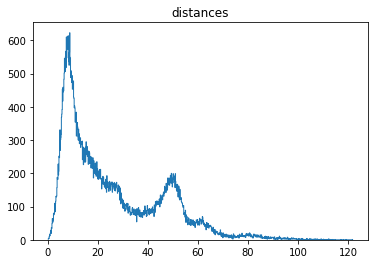

In [16]:
plt.hist(distances[~np.isnan(distances)], bins=1000, histtype='step')
plt.title('distances')

In [17]:
np.isnan(cGal.U).sum()
#for k in data.keys():
#    print(data[k][np.isnan(cGal.U)])
print(distances[np.isnan(cGal.U)], Ag[np.isnan(cGal.U)])

int_average_g
------------- ebv
---


In [18]:
locgalaxiesfile = '/Users/landerson/Dropbox (Simons Foundation)/data/Misc/NearbyGalaxies.dat'
locgaldata = Table.read(locgalaxiesfile, format='ascii')
gcfile = '/Users/landerson/Dropbox (Simons Foundation)/data/Misc/Harris-globclust.fits'
gcdata = Table.read(gcfile, format='fits')
locGalc = coord.SkyCoord(ra=locgaldata['RA'], dec=locgaldata['Dec'], unit=(u.hourangle, u.deg))
gcc     = coord.SkyCoord(ra=gcdata['ra'],     dec=gcdata['dec'], unit=(u.hourangle, u.deg))

locGalcGal = locGalc.transform_to(coord.Galactic)
gccGal = gcc.transform_to(coord.Galactic)

In [19]:
from sklearn.neighbors import KDTree as kdtree
import pandas as pd
import matplotlib as mpl

In [45]:
treedata = pd.DataFrame(data={'u':cGal.u/(15.*u.kpc), 
                              'v':cGal.v/(15.*u.kpc), 
                              'w':cGal.w/(15.*u.kpc),
                              'U':cGal.U/(120*u.km/u.s),
                              'V':cGal.V/(120*u.km/u.s), 
                              'W':cGal.W/(120*u.km/u.s)})

In [46]:
treedataHigh = treedata.iloc[np.where(np.abs(cGalactic.b) >= 30.*u.deg)[0]]

In [47]:
tree = kdtree(treedataHigh)

In [54]:
(ind, dist) = tree.query_radius(treedataHigh, 0.1, count_only = False, return_distance = True)

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


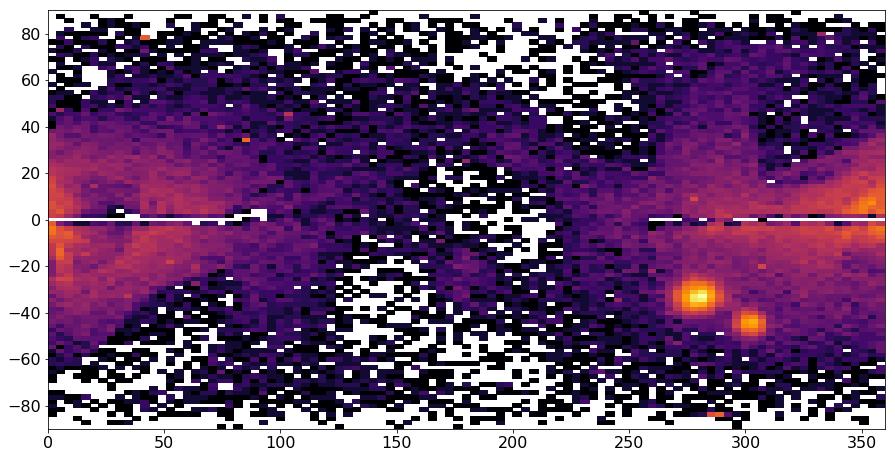

In [55]:
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'aspect': 'equal'})
nbins = 100
xbins = np.linspace(0, 360, nbins)
ybins = np.linspace(-90, 90, nbins)

H, xe, ye = np.histogram2d(cGalactic.l, cGalactic.b, bins=(xbins, ybins))
im = ax.pcolormesh(xe, ye, H.T,
      cmap='inferno', norm=mpl.colors.LogNorm())#, vmax=20) #, vmin=-100, vmax=100)
    

In [58]:
for i in ind:
    if len(i) > 3: print(i)

[2419 2421 2423 2416 2422]
[2421 2423 2416 2422]
[2421 2423 2416 2417 2422]
[2419 2421 2423 2416 2422]
[3145 3148 3141 3146 3151 3150]
[3145 3150 3142 3143]
[3145 3150 3142 3143]
[3145 3141 3150 3142 3143]
[3148 3141 3146 3151 3150]
[3148 3141 3146 3151]
[3145 3141 3146 3150 3142 3143]
[3148 3141 3146 3151]
[3279 3227 3193 3292 3234 3233 3269 3156]
[3196 3229 3182 3172 3280 3291 3245 3266 3300 3248 3187 3270 3282 3254
 3160 3265 3283 3175 3165 3159 3262 3180 3167 3234 3250 3263 3176 3281
 3285 3238]
[3229 3182 3172 3280 3291 3245 3266 3300 3248 3187 3270 3282 3160 3265
 3283 3165 3159 3162 3262 3167 3250 3263 3168 3176 3288 3257 3164 3197
 3183 3188 3161 3261 3296 3228 3273 3281 3260 3255 3249 3264 3178 3285
 3205 3295 3238 3191 3287]
[3232 3177 3192 3182 3172 3170 3245 3174 3290 3259 3293 3186 3266 3300
 3248 3187 3282 3254 3160 3265 3272 3193 3165 3162 3189 3262 3292 3180
 3167 3173 3250 3233 3163 3263 3286 3185 3216 3168 3176 3257 3164 3183
 3188 3252 3161 3261 3267 3258 3296 3228 3

In [59]:
clumps = []
for i in ind:
    if len(i)>3: 
        #print(i, j)
        clumps.append(i)
print(len(clumps))

496


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


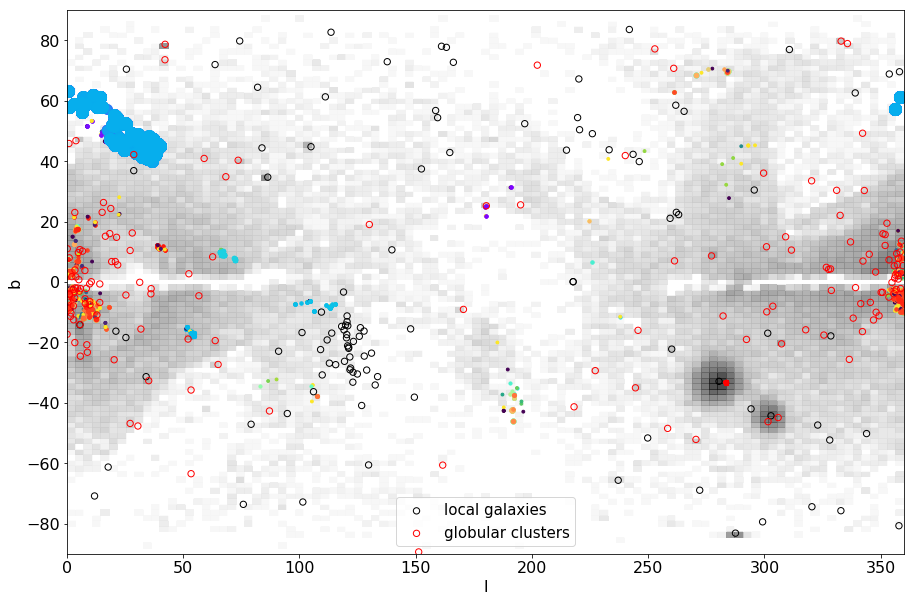

In [60]:
#figAll, axAll = plt.subplots()
figSky, axSky = plt.subplots(figsize=(15, 10))
colors=iter(plt.cm.rainbow(np.linspace(0,1,len(clumps))))
axSky.pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)

for j in range(len(clumps)):
    color = next(colors)
    axSky.scatter(cGalactic.l[clumps[j]], cGalactic.b[clumps[j]], s=len(clumps[j])*2, c=color)
axSky.scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies')
axSky.scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters')
axSky.set_xlabel('l')
axSky.set_ylabel('b')
axSky.set_xlim(0, 360)
axSky.set_ylim(-90, 90)
axSky.legend(fontsize=15)
#plt.close(fig)

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(-90, 90)

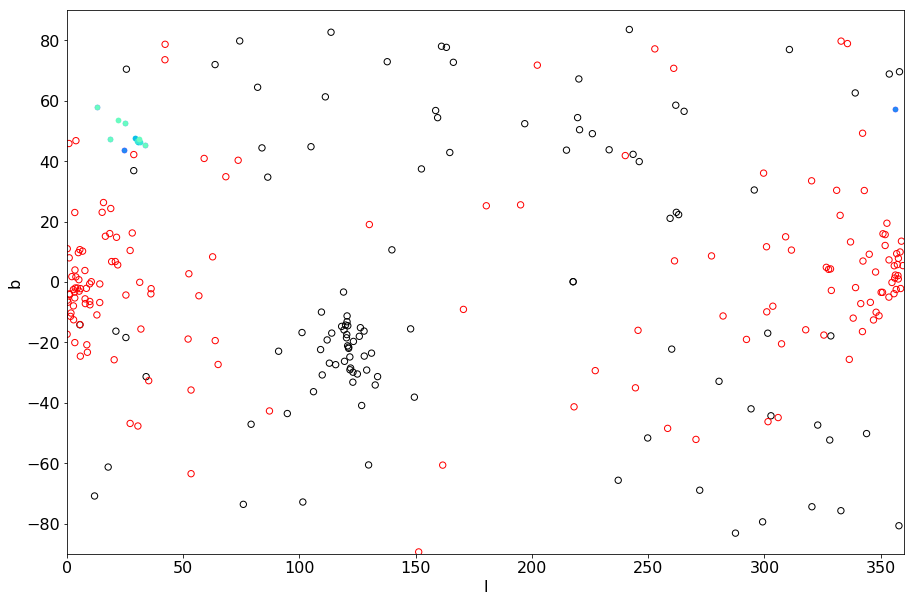

In [53]:
#figAll, axAll = plt.subplots()
figSky, axSky = plt.subplots(figsize=(15, 10))
colors=iter(plt.cm.rainbow(np.linspace(0,1,len(clumps))))
mpl.rc('font',**{'family':'sans-serif', 'serif':['Computer Modern Serif'], 
             'sans-serif':['Helvetica'], 'size':16, 
             'weight':500, 'variant':'normal'}) 
for j, ci in enumerate(clumps):
    samesies = 0
    for k in range(j):
        same = np.in1d(clumps[j], clumps[k])
        samesies += np.sum(same)
    #if clumps[j] != clumps[j-1]
    if samesies < 1:
        small = treedata.iloc[clumps[j]]
        fig, ax = plt.subplots(ncols=5, figsize=(20, 5))
        xx = [small.u, small.v, small.w]
        yy = [small.v, small.w, small.u]
        vxx = [small.U, small.V, small.W]
        vyy = [small.V, small.W, small.U]
        lxx = ['u', 'v', 'w']
        lyy = ['v', 'w', 'u']
        color = next(colors)
        for i, (x, y, vx, vy, lx, ly) in enumerate(zip(xx, yy, vxx, vyy, lxx, lyy)):
            ax[i].quiver(x, y, vx, vy, color=color)
            ax[i].set_xlabel(lx)
            ax[i].set_ylabel(ly)
            #axAll.quiver(x, y, vx, vy)
        ax[3].scatter(cGalactic.l[clumps[j]], cGalactic.b[clumps[j]], c=color)
        ax[3].set_xlabel('l')
        ax[3].set_ylabel('b')
        ax[4].scatter(cGalactic.l[clumps[j]], distances[clumps[j]], c=color)
        ax[4].set_xlabel('l')
        ax[4].set_ylabel('d [kpc]')
        plt.tight_layout()
        fig.savefig('rrLyrae_kdtree_{0:03d}.png'.format(j))
        plt.close(fig)
    axSky.scatter(cGalactic.l[clumps[j]], cGalactic.b[clumps[j]], s=len(clumps[j])*10, c=color)

axSky.scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black')
axSky.scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red')
axSky.set_xlabel('l')
axSky.set_ylabel('b')
axSky.set_xlim(0, 360)
axSky.set_ylim(-90, 90)
#plt.close(fig)